
**Exploring the Significance of Temperature under Conditions of Compromised Equivalency**

Randomized Controlled Trials (RCTs) are fundamental in scientific research for evaluating the effectiveness of interventions or treatments. The core principle of an RCT lies in its ability to randomly assign participants into treatment and control groups, ensuring that any differences observed in outcomes can be confidently attributed to the intervention rather than other factors. This randomization process helps mitigate biases and ensures the validity of the study's findings.

However, even in well-designed RCTs, issues can arise during data collection or experimental execution that compromise the comparability between treatment and control groups. One critical aspect is the equivalency between these groups. Equivalency ensures that both groups are similar in all aspects except for the treatment they receive. Any deviations from equivalency can lead to misleading conclusions about the treatment effect.

In our demonstration, we illustrated a scenario where errors occurred in the experimental setup of an RCT. The experiment involved households randomly selected from different zip codes experiencing varying temperature levels, which inadvertently violated the equivalency principle. We showcased this by plotting temperature patterns using line plots and illustrating the distribution of climate categories across treatment and control groups using bar charts.

These visualizations highlighted the variability in temperature exposure across groups, indicating potential differences that could affect energy usage patterns. Such deviations from equivalency underscore the importance of statistical tests like t-tests and Levene's test to rigorously assess and address any discrepancies between treatment and control groups. These tests are essential for ensuring the robustness and validity of conclusions drawn from statistical models like PanelOLS, which rely on the assumption of equivalency to provide accurate insights into treatment effects.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
from scipy.stats import norm  # Import norm from scipy.stats

!pip install linearmodels
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

!pip install prophet
from prophet import Prophet


In the provided code, I simulated an RCT scenario involving households across different climate categories (Extreme Hot, Hot, Moderate, Mild). Each household is assigned a treatment or control status randomly. The temperature data, generated based on climate categories and hourly variations, serves as a crucial factor influencing the energy usage patterns we intend to study.

**Temperature Patterns - Treatment vs Control Groups:**

The first plot illustrates the average temperature patterns for treatment and control groups across different hours of the day. This visualization is crucial as it shows how temperature, a potential confounding factor, varies between the two groups. It helps us understand if there are any systematic differences in temperature exposure that could affect our energy usage analysis.

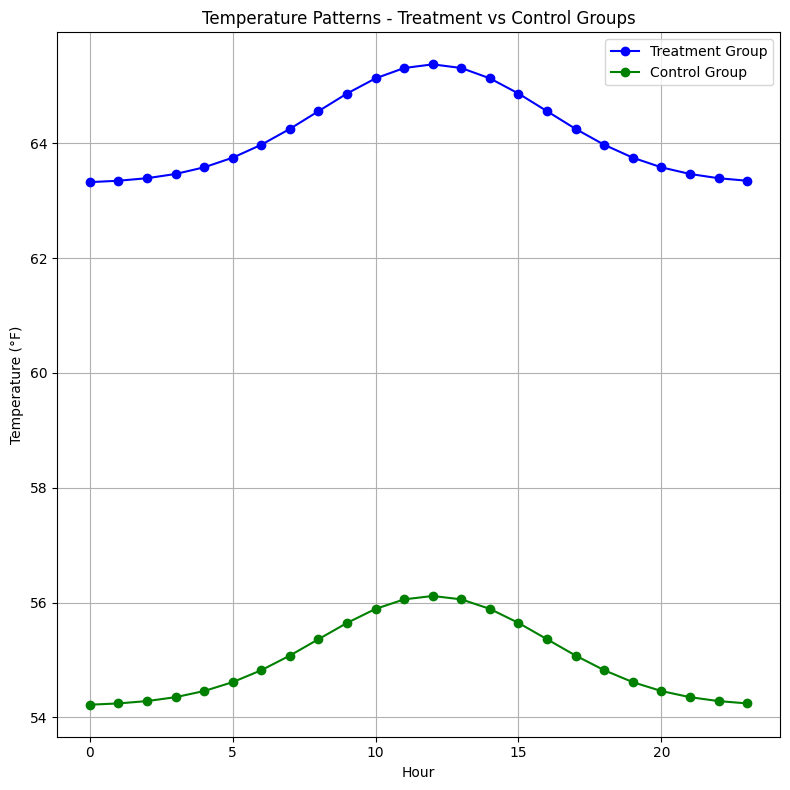

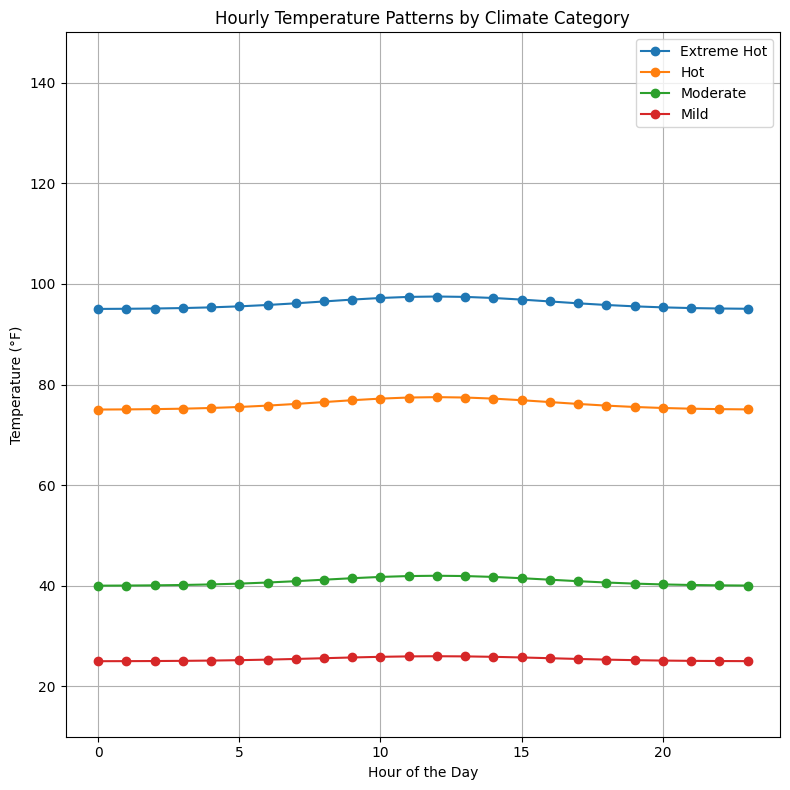

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_households = 100
n_hours = 24
treatment_households = 50

# Create base DataFrame with correct household IDs
households = np.repeat(np.arange(n_households), n_hours)
df = pd.DataFrame({
    'household_id': households,
    'hour': np.tile(np.arange(n_hours), n_households),
    'treatment': np.repeat(np.concatenate([np.ones(treatment_households), np.zeros(n_households - treatment_households)]), n_hours)
})

# Generate climate categories and assign to households
climate_categories = np.repeat(['Extreme Hot', 'Hot', 'Moderate', 'Mild'], n_households // 4)
np.random.shuffle(climate_categories)
df['climate'] = np.repeat(climate_categories, n_hours)

# Function to generate temperature based on climate category
def generate_temperature(hour, climate):
    if climate == 'Extreme Hot':
        temp_base = 95  # Base temperature for Extreme Hot
        temp_peak = 120  # Peak temperature for Extreme Hot
    elif climate == 'Hot':
        temp_base = 75  # Base temperature for Hot
        temp_peak = 100  # Peak temperature for Hot
    elif climate == 'Moderate':
        temp_base = 40  # Base temperature for Moderate
        temp_peak = 60  # Peak temperature for Moderate
    elif climate == 'Mild':
        temp_base = 25  # Base temperature for Mild
        temp_peak = 35  # Peak temperature for Mild

    # Generate a normal distribution centered at noon (hour 12)
    temp_curve = norm.pdf(hour, loc=12, scale=4)  # Normal distribution centered at noon

    # Scale the temperature curve based on base and peak temperatures
    temperature = temp_base + temp_curve * (temp_peak - temp_base)

    return temperature

# Generate temperature data for each household based on climate category
df['temperature'] = [generate_temperature(hour, climate) for hour, climate in zip(df['hour'], df['climate'])]

# Aggregate temperature data for treatment and control groups
agg_df = df.groupby(['hour', 'treatment'])['temperature'].mean().reset_index()

# Plotting temperature patterns separately for treatment and control groups
fig, ax = plt.subplots(figsize=(8, 8))

# Treatment group plot
treatment_data = agg_df[agg_df['treatment'] == 1]
ax.plot(treatment_data['hour'], treatment_data['temperature'], label='Treatment Group', marker='o', linestyle='-', color='blue')

# Control group plot
control_data = agg_df[agg_df['treatment'] == 0]
ax.plot(control_data['hour'], control_data['temperature'], label='Control Group', marker='o', linestyle='-', color='green')

ax.set_xlabel('Hour')
ax.set_ylabel('Temperature (°F)')
ax.set_title('Temperature Patterns - Treatment vs Control Groups')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show();

# Plotting hourly temperature profiles by climate category on a single plot
plt.figure(figsize=(8, 8))

# Iterate over each climate category and plot hourly temperature
for climate in ['Extreme Hot', 'Hot', 'Moderate', 'Mild']:
    # Subset data for the current climate category
    climate_data = df[df['climate'] == climate]

    # Group by hour and calculate mean temperature
    hourly_mean_temp = climate_data.groupby('hour')['temperature'].mean()

    # Plot hourly temperature profile
    plt.plot(hourly_mean_temp.index, hourly_mean_temp.values, marker='o', linestyle='-', label=climate)


plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°F)')
plt.title('Hourly Temperature Patterns by Climate Category')
plt.grid(True)
plt.legend()
plt.ylim(10, 150)  # Adjust ylim based on your temperature range

plt.tight_layout()
plt.show();


df.head(5)

plt.show();

# Blocking on Temperature failed:

The analysis of temperature data between the treatment and control groups in this Randomized Controlled Trial (RCT) reveals significant concerns about the effectiveness of blocking on temperature. The substantial differences in mean and median temperatures, along with the disparities in quartile values, indicate a lack of equivalency between the two groups. While the standard deviations are similar, suggesting comparable variability within each group, this alone is insufficient to establish temperature equivalence. The Mann-Whitney U test results, with an extremely low p-value, further confirm a statistically significant difference in temperature distributions between the groups. These findings collectively suggest that the blocking procedure for temperature was not successful in achieving the desired balance between the treatment and control groups. This outcome raises important questions about the implementation of the blocking strategy and may necessitate a reevaluation of the experimental design or the application of additional statistical adjustments to ensure proper temperature control across groups. The lack of temperature equivalency could potentially impact the interpretation of treatment effects in this RCT, highlighting the importance of addressing this issue for the validity of the study's conclusions.

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Assuming 'df' contains your DataFrame with temperature data and treatment assignment

# Calculate basic statistics for temperature by treatment group
summary_stats = df.groupby('treatment')['temperature'].describe()

# Calculate Mann-Whitney U test
treatment_temps = df[df['treatment'] == 1]['temperature']
control_temps = df[df['treatment'] == 0]['temperature']
mannwhitney = mannwhitneyu(treatment_temps, control_temps)

# Add Mann-Whitney U test results to summary table
summary_stats.loc['Mann-Whitney U statistic'] = mannwhitney.statistic
summary_stats.loc['Mann-Whitney U p-value'] = mannwhitney.pvalue

# Format numbers from scientific to decimals
summary_stats = summary_stats.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x)

# Print summary table
summary_stats


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0.0,1200.0000,54.9977,27.5795,25.0111,25.9667,41.2099,77.2004,97.4934
1.0,1200.0000,64.1642,27.5521,25.0111,40.0876,75.3374,95.0568,97.4934
Mann-Whitney U statistic,835200.0000,835200.0000,835200.0000,835200.0000,835200.0000,835200.0000,835200.0000,835200.0000
Mann-Whitney U p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


**Hourly Temperature Patterns by Climate Category:**

The second plot aggregates and displays hourly temperature profiles for each climate category (Extreme Hot, Hot, Moderate, Mild). This plot allows us to visualize how temperature varies throughout the day across different climate conditions. Such insights are essential for understanding the environmental context in which the study is conducted and its potential impact on energy usage.

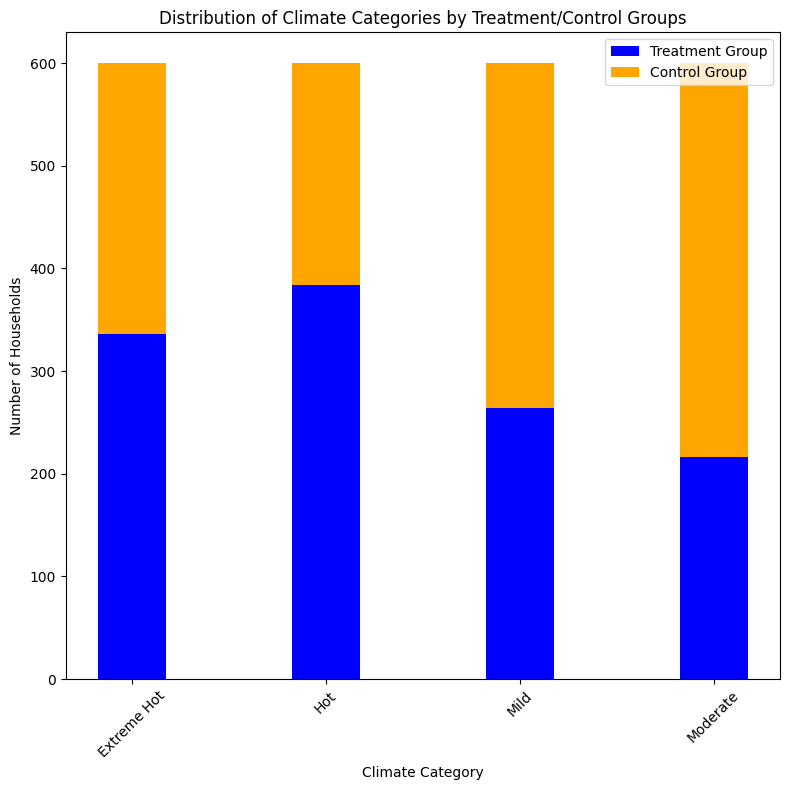

In [56]:
# Visualizing climate categories by treatment/control groups
climate_counts = df.groupby(['treatment', 'climate']).size().unstack()

# Plotting
plt.figure(figsize=(8, 8))
width = 0.35

# Plot for treatment group (1)
p1 = plt.bar(climate_counts.columns, climate_counts.loc[1], width, label='Treatment Group', color='blue')

# Plot for control group (0), shifted by width
p2 = plt.bar(climate_counts.columns, climate_counts.loc[0], width, bottom=climate_counts.loc[1], label='Control Group', color='orange')

plt.xlabel('Climate Category')
plt.ylabel('Number of Households')
plt.title('Distribution of Climate Categories by Treatment/Control Groups')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show();


# Including temperature in the model

The provided code simulates household energy usage under varying conditions and conducts regression analysis to understand the impact of treatment on energy consumption.

Initially, energy usage patterns are generated based on random base and peak loads for households. Treatment households experience adjusted energy loads during peak and pre-cooling hours, while control households maintain a consistent load pattern. The dataset is then prepared for regression analysis by incorporating hourly temperature data and converting hour into a categorical variable.

Using the PanelOLS regression model, the analysis explores how treatment (adjusting energy usage) and **temperature** influence energy consumption across households. Results are summarized through regression coefficients and statistical tests, followed by visualizations that compare average energy usage and temperature profiles between treatment and control groups.

Overall, the approach integrates statistical modeling with visual insights to examine how experimental conditions and temperature variations affect household energy usage, emphasizing the importance of robust experimental design and analysis in interpreting intervention outcomes.

# Significance of the significant p-value of temperature  

The coefficient for **temperature** is 0.0141, with a statistically significant p-value of 0.0019. This indicates that temperature has a significant and positive effect on energy usage, increasing it by approximately 0.0141 kW for each one-degree Fahrenheit rise, while controlling for other variables. However, this finding raises concerns regarding the equivalency assumption in experimental designs, which posits that treatment and control groups should be comparable on average, except for the treatment itself. The positive p-value for temperature suggests that there are systematic differences between the treatment and control groups related to temperature, potentially introducing confounding factors into the interpretation of treatment effects. Consequently, caution is warranted when attributing observed differences in energy usage solely to the treatment, as variations in temperature could also significantly influence the outcomes.  


In the regression analysis, the coefficient for **treatment** is estimated at 0.0578, with a standard error of 0.7463. This results in a T-statistic of 0.0775 and a corresponding p-value of 0.9382, indicating that the observed effect of the treatment on energy usage is not statistically significant. This suggests that any apparent association between the treatment and energy usage could be attributed to random chance rather than a true causal effect. The wide confidence interval (-1.4056 to 1.5212) further supports this interpretation, indicating that the true effect of the treatment on energy usage could range from a slight decrease to a slight increase, including the possibility of no effect at all. Therefore, based on this analysis, there is insufficient evidence to conclude that the treatment has a meaningful impact on energy usage in this context. This revised explanation emphasizes the implications of the findings, particularly regarding the challenges to the equivalency assumption and the interpretation of treatment effects, while maintaining a logical flow.



Fixed Effects Regression Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:           energy_usage   R-squared:                        0.7176
Estimator:                   PanelOLS   R-squared (Between):              0.2904
No. Observations:                2400   R-squared (Within):               0.8239
Date:                Mon, Jul 22 2024   R-squared (Overall):              0.7176
Time:                        19:37:07   Log-likelihood                   -6309.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      124.44
Entities:                         100   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(48,2351)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             1

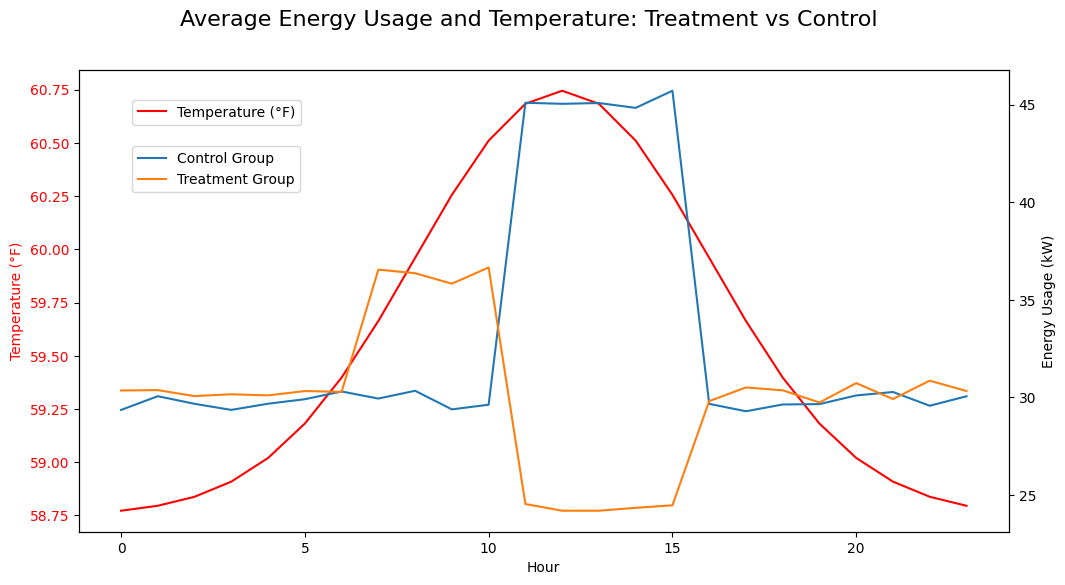

In [57]:
df.head(5)

# Function to generate energy usage
def generate_energy_usage(hour, is_treatment, base_load, peak_load, peak_hours, pre_cooling_hours):
    if is_treatment:
        if hour in peak_hours:
            return base_load * 0.8  # Reduced load during peak hours for treatment group
        elif hour in pre_cooling_hours:
            return base_load * 1.2  # Increased load during pre-cooling for treatment group
        else:
            return base_load
    else:
        if hour in peak_hours:
            return peak_load  # Higher load during peak hours for control group
        else:
            return base_load

# Generate energy usage
base_loads = np.random.uniform(25, 35, n_households)  # Random base load kW per household
peak_loads = np.random.uniform(40, 50, n_households)  # Random peak load kW per household
peak_hours = range(11, 16)  # 11 AM to 3 PM
pre_cooling_hours = range(7, 11)  # 7 AM to 10 AM

# Vectorized operation to generate energy usage for each household
df['energy_usage'] = [
    generate_energy_usage(hour, treatment, base_loads[household], peak_loads[household], peak_hours, pre_cooling_hours)
    for hour, treatment, household in zip(df['hour'], df['treatment'], df['household_id'])
]

df.head(5)

# Add some random noise
df['energy_usage'] += np.random.normal(0, 2, len(df))

df.head(5)

# Ensure non-negative energy usage
df['energy_usage'] = df['energy_usage'].clip(lower=0)

# Assign climate categories to households
climate_categories = np.repeat(['Extreme Hot', 'Hot', 'Moderate', 'Mild'], n_households // 4)
np.random.shuffle(climate_categories)

# Repeat climate categories for each hour in each household
df['climate'] = np.repeat(climate_categories, n_hours)

df.head(5)

# Convert hour to categorical
df['hour2'] = pd.Categorical(df['hour'])

df.head(5)

# Assuming x1 is a variable of interest (randomly generated for demonstration)
df['x1'] = np.random.normal(0, 1, size=len(df))

# Create a panel DataFrame
df_s = df.set_index(['household_id', 'hour'])

df_s.head(5)

# Specify the regression model
mod = PanelOLS.from_formula('energy_usage ~ 1 + hour2*treatment + temperature', drop_absorbed=True, check_rank=False, data=df_s)

# Fit the model
res = mod.fit()

# Print regression results
print("Fixed Effects Regression Results:")
print(res)

# Additional diagnostics
print(res.summary)

# Plot average energy usage and temperatures for treatment and control groups
df = df.sort_values(by='hour')  # Sort df by 'hour' for plotting

df.head(5)


# Plot average energy usage and temperatures for treatment and control groups
df = df.sort_values(by='hour')  # Sort by hour for plotting

fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggregate temperature data at the hourly level
temperature_data = df.groupby('hour')['temperature'].mean()

# Plot temperatures on primary axis
ax1.plot(temperature_data.index, temperature_data.values, label='Temperature (°F)', color='red', linestyle='-')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary axis for energy load
ax2 = ax1.twinx()
for treatment in [0, 1]:
    data = df[df['treatment'] == treatment].groupby('hour')['energy_usage'].mean()
    ax2.plot(data.index, data.values, label=f'{"Control" if treatment == 0 else "Treatment"} Group')

ax2.set_ylabel('Energy Usage (kW)')
ax2.tick_params(axis='y')

# Add title and legends
fig.suptitle('Average Energy Usage and Temperature: Treatment vs Control', fontsize=16)
ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.85))

# Calculate and print the average treatment effect during peak hours
peak_hours_data = df[df['hour2'].isin(peak_hours)]
treatment_effect = peak_hours_data.groupby('treatment')['energy_usage'].mean()
print(f"Average Treatment Effect during peak hours: {treatment_effect[0] - treatment_effect[1]:.2f} kW")

# Display the plot without showing unwanted messages
plt.show();



# Interpretation of RCT Results on Energy Usage

## Model Overview

- **Dependent Variable**: Energy Usage
- **R-squared**: 0.7176 (Overall), 0.8239 (Within)
- **Observations**: 2400
- **Entities**: 100
- **Time Periods**: 24

## Key Findings

### 1. Temperature Effect

- **Coefficient**: 0.0137
- **P-value**: 0.0000 (highly significant)
- **Interpretation**: For each 1-degree increase, energy usage rises by 0.0137 kW.

### 2. Treatment Effect

- **Main Effect Coefficient**: 0.8724
- **P-value**: 0.1983 (not significant)
- **However**: Significant interactions with specific hours.

### 3. Hour Effects

- **Hours 11-15**: Large, significant increases in energy usage.
- Likely represents peak energy usage times.

### 4. Treatment-Hour Interactions

- Significant negative interactions during peak hours (11-15).
- Indicates treatment reduces energy usage substantially during these hours.

### 5. Average Treatment Effect During Peak Hours

- **Reported Effect**: 20.80 kW reduction.
- Aligns with large negative coefficients for treatment-hour interactions.

## Interpretation

1. **Blocking Effectiveness**:
   - Significant temperature coefficient suggests imperfect blocking.
   - Temperature variations still explain some energy usage variation.

2. **Treatment Effect**:
   - Not significant overall, but highly effective during specific hours.

3. **Time-Varying Treatment Effect**:
   - Effectiveness varies substantially by hour.
   - Largest effects during peak hours (11-15).

4. **Magnitude of Effect**:
   - 20.80 kW average reduction during peak hours is substantial.

5. **Model Fit**:
   - High R-squared values, especially within R-squared (0.8239).
   - Model explains a large portion of energy usage variation.

## Conclusions

1. RCT reveals significant time-varying treatment effect.
2. Major energy reductions during peak hours.
3. Blocking on temperature not entirely successful.
4. Treatment effectiveness highly dependent on time of day.
5. Model captures important patterns despite imperfect temperature blocking.

**Failed Blocking**


Blocking is a technique used in experimental design to account for potential confounding variables by creating groups that are similar in certain characteristics. In the case of energy efficiency programs, temperature may be a variable that researchers attempt to control. However, if blocking fails, it means that the treatment and control groups differ significantly in the blocked variable, which can lead to biased results. For instance, if one group experiences higher temperatures than the other during the trial, any observed differences in energy usage may be attributed to temperature fluctuations rather than the treatment itself. This undermines the RCT's ability to isolate the effect of the intervention, making it difficult to draw accurate conclusions about the program's effectiveness.


**Violation of Equivalency**


Equivalency in RCTs refers to the principle that the treatment and control groups should be as similar as possible, except for the treatment being tested. This similarity is crucial for establishing a valid counterfactual—what would have happened in the absence of the treatment. If equivalency is violated, it means that the groups differ in ways that could influence the outcome, leading to confounding effects. For example, if the treatment group consists of households that are generally more energy-conscious than those in the control group, the results may reflect these underlying differences rather than the impact of the treatment.
Violations of equivalency can arise from selection bias, where the method of assigning participants to groups leads to systematic differences. This can happen if randomization is not properly implemented or if there are external factors that influence who participates in the study. Such violations can significantly compromise the internal validity of the study, making it challenging to attribute observed changes in energy usage directly to the treatment.